In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import colors as mcolors

import tclab
import time
from IPython.display import display, clear_output

import package_LAB
from importlib import reload
package_LAB = reload(package_LAB)

from package_DBR import myRound, SelectPath_RT, Delay_RT, FO_RT, FOPDT, SOPDT, FOPDT_cost, SOPDT_cost, Process, Bode
from package_LAB import PID_RT,LeadLag_RT,IMC_tuning

In [7]:
#SOPDT PV
Kp = 0.46575892823243076
T1p = 132.04151002516983
T2p = 7.647730018039972
thetap = 0.0004910330468864688

#SOPDT DV
Kd = 0.36816132905697
T1d = 128.19758463380253
T2d = 26.094509776696448
thetad = 2.000174864808916

In [8]:
TSim = 2200
Ts = 1
N = int(TSim/Ts) + 1

MV0 = 50
DV0 = 50
PV0 = 75
SPPath = {0:50, 5:50, 50:50, 80:50, TSim: 50}
MVPath = {0:1, 100:0, TSim:1}
#MVPath = {0:1, 100:0, TSim:1}

gamma = 0.6 
Kc,Ti,Td = IMC_tuning(Kp,T1p,T2p,thetap,gamma,'SOPDT')
print(Kc,Ti,Td)
alpha = 1
MVMin = 0
MVMax = 100

3.785622825343554 139.6892400432098 7.229030808202924


In [9]:

# # OLP + no FF
# ManPath = {0: True, TSim: True} # Path for Man
# MVManPath = {0: MV0 , Tsim : MV0} #path for MVMan
# SPPath = {0: PV0, TSim: MV0} # Path for SP, always the same in most cases
# DVPath = {0: 50.0, 1000: 60, TSim: 60.0} # Path for DV
# ActivateFF = False
# ManFF = True

# OLP FF          
ManPath = {0: True, TSim: True} # Path for Man
MVManPath = {0: MV0, TSim: MV0} # Path for MVMan
SPPath = {0: PV0, TSim: PV0} # Path for SP, always the same in most cases
DVPath = {0: 50.0, 1000: 60,  TSim: 60.0} # Path for DV
ActivateFF = True
ManFF = True

# #CLP + no FF
# ManPath = {0:True, 750: False, TSim: False} # Path for Man
# MVManPath = {0: MV0, TSim: MV0}                          # Path for MVMan
# SPPath = {0: PV0, 800:PV0-10, TSim: PV0-10}                             # Path for SP, always the same in most cases
# DVPath = {0: DV0, 1500: DV0+10, TSim: DV0+10}                  # Path for DV
# ActivateFF = False
# ManFF= False

# # FF + CLP
# ManPath = {0: True, 750: False,  TSim: False}# Path for Man
# MVManPath = {0: MV0, TSim: MV0}                         # Path for MVMan
# SPPath = {0: PV0,800:PV0-10, TSim: PV0-10}                            # Path for SP, always the same in most cases
# DVPath = {0: DV0,1500: DV0+10, TSim: DV0+10}                 # Path for DV
# ActivateFF = True
# ManFF= False

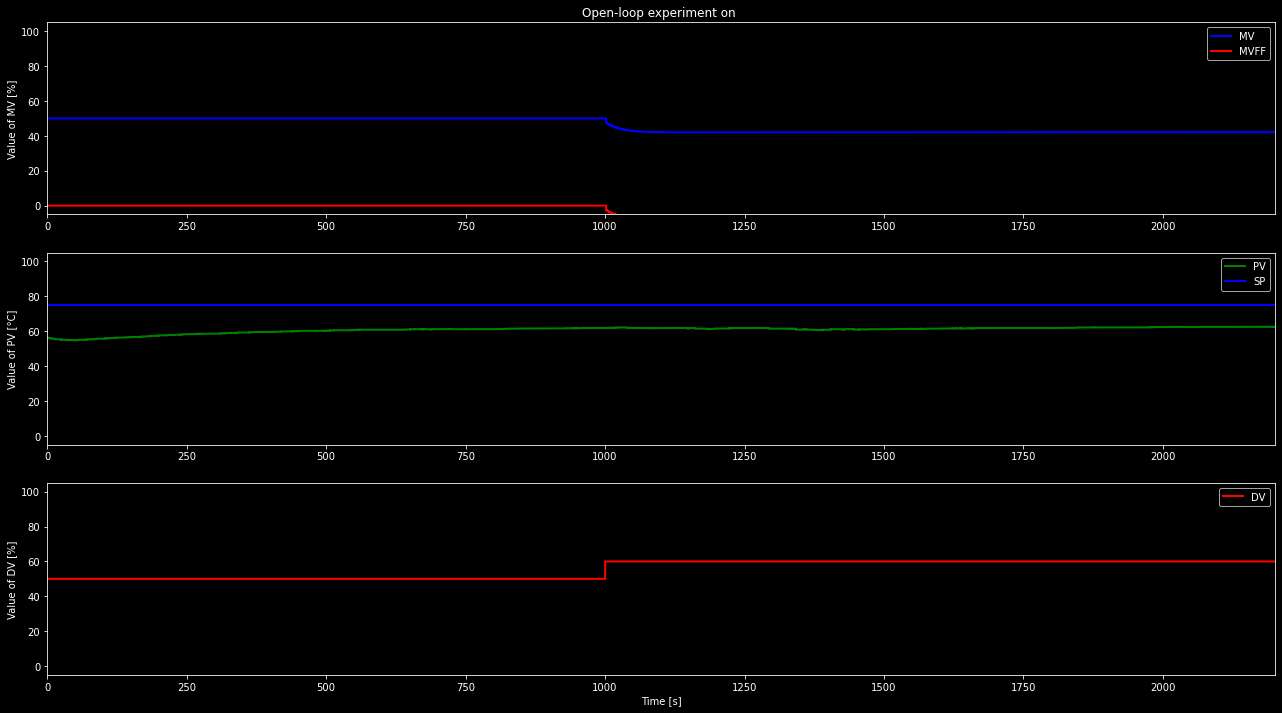

TCLab disconnected successfully.


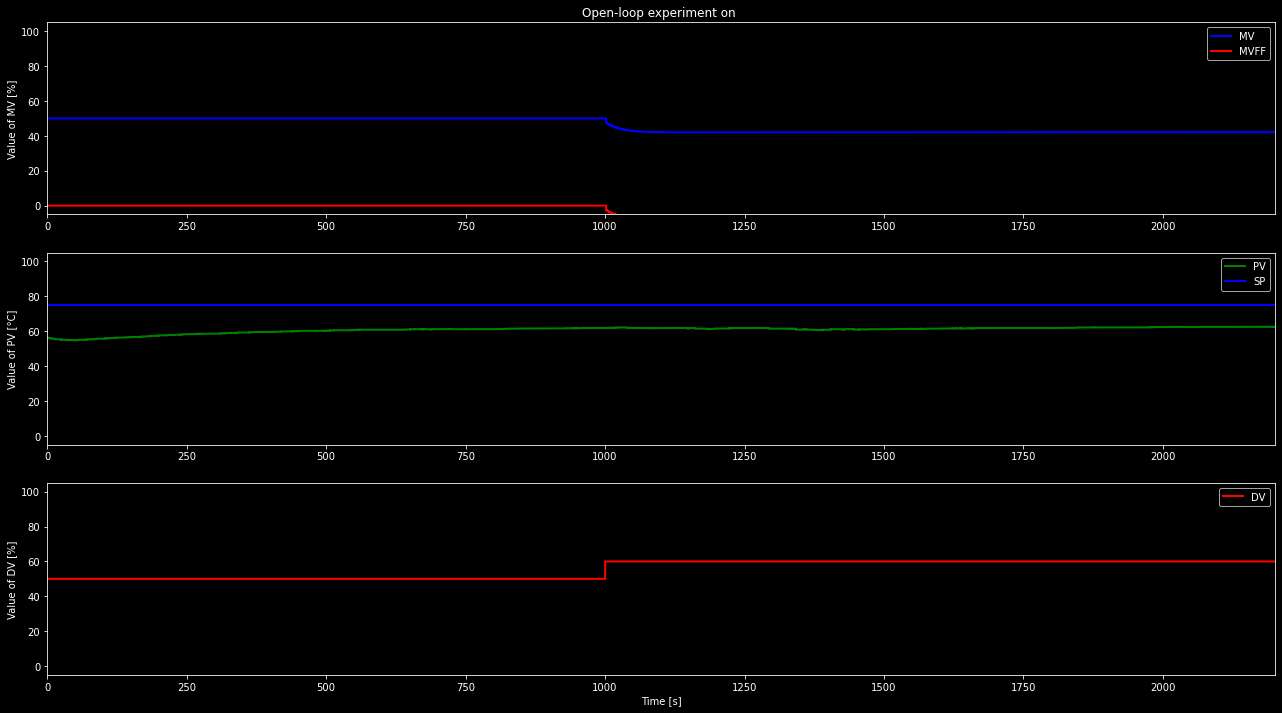

In [10]:
t = []
MVP=[]
MVI=[]
MVD=[]
DV = []
PV = []
SP = []
MV = []
E = []
MVFF = []
MVMan=[]
Man = []
MVFFDelay = []
MVFFLL = []
MVDelayp = []
MVDelayd = []
PV1p = []
PV2p = []
PV1d = []
PV2d = []

lab = tclab.TCLab()

fig, (ax1, ax2, ax3) = plt.subplots(3,1)
fig.set_figheight(12)
fig.set_figwidth(22)

l1, = ax1.step([0,1],[0,100],'b-',linewidth=2,label='MV',where='post')
l11, = ax1.step([0,1],[0,100],'r-',linewidth=2,label='MVFF',where='post')
ax1.set_ylabel('Value of MV [%]')
ax1.set_title('Open-loop experiment on ')
ax1.legend(loc='best')

l2, = ax2.step([0,1],[0,100],'g-',linewidth=2,label='PV',where='post')
l22, = ax2.step([0,1],[0,100],'b-',linewidth=2,label='SP',where='post')
ax2.set_ylabel('Value of PV [°C]')
ax2.legend(loc='best')

l3, = ax3.step([0,1],[0,100],'r-',linewidth=2,label='DV',where='post')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Value of DV [%]')
ax3.legend(loc='best')

for i in range(0,N):
    t.append(i*Ts)
    
    #SP DV
    SelectPath_RT(SPPath,t,SP)
    SelectPath_RT(DVPath,t,DV)
    
    #FeedForward
    Delay_RT(DV - DV0*np.ones_like(DV),np.max([thetad-thetap,0]),Ts,MVFFDelay)
    LeadLag_RT(MVFFDelay,-Kd/Kp,T1p,T1d,Ts,MVFFLL)
    LeadLag_RT(MVFFLL,int(ActivateFF),T2p,T2d,Ts,MVFF)
    
    #
    SelectPath_RT(ManPath,t,Man)
    SelectPath_RT(MVManPath,t,MVMan)
    
    #PID
    PID_RT(SP,PV,Man,MVMan,MVFF,Kc,Ti,Td,alpha,Ts,MVMin,MVMax,MV,MVP,MVI,MVD,E,ManFF,PV0)
    
    #TCLab
    lab.Q1(MV[-1])
    lab.Q2(DV[-1])
    
    #Disturbance dynamics D(s)
    Delay_RT(DV - DV0*np.ones_like(DV),thetad,Ts,MVDelayd,0)
    FO_RT(MVDelayd,Kd,T1d,Ts,PV1d,0)
    FO_RT(PV1d,1,T2d,Ts,PV2d,0)
    
    PV.append(lab.T1)
    
    l1.set_data(t,MV)
    l11.set_data(t,MVFF)
    l2.set_data(t,PV)
    l22.set_data(t,SP)
    l3.set_data(t,DV)
    
    clear_output(wait=True)
    
    # Remove if increasing x-axis length is not desired
    ax1.set_xlim(0, t[-1]+1)
    ax2.set_xlim(0, t[-1]+1)
    ax3.set_xlim(0, t[-1]+1)
    
    #if i > 1:
        #ax1.set_ylim(myRound(np.min(MV),5)-5, myRound(np.max(MV),5)+5)
        #ax2.set_ylim(myRound(np.min(PV),5)-5, myRound(np.max(PV),5)+5)
        #ax2.set_ylim(myRound(np.min(SP),5)-5, myRound(np.max(SP),5)+5)
        #ax3.set_ylim(myRound(np.min(DV),5)-5, myRound(np.max(DV),5)+5)        
    
    display(fig) 


lab.close()
    


## PLOT